# Deep Feature Engineering
As an aside, as of receiving my report card a few days ago, I've officially completed the academic requirements for the CS degree, after four fun (besides compilers...) semesters and with a middling 3.2 GPA.

In today's recreational coding session, we'll be taking a look at some nonlinear dimensionality reduction techniques. Hopefully, this can be a sort of "BYE SISTER" for linear dimensionality reduction techniques, because they suck.

> (_I'll_, because none of my buddies want to do recreational machine learning...)

In my internship this past semester (part-time, for-credit, that the CS department was nice enough to hook me up with), our project was a pretty open-ended data analysis task involving noisy, high-dimension computational biology data the NOAA had. The data was giving the tools the biologists were familiar with some trouble. Our boss said that principal component analysis, which is a linear dimensionality reduction technique, was the tool people in the domain used for this task and pointed us to it as a reasonable starting point.

However, the data was "real-life" enough that PCA didn't work; rather than attempt to _make it work_, my team, in a show of unashamed bias towards computational methods, decided we were going to find a novel result with them. (We study machine learning, not statistics, so instead of thinking hard and solving the problem elegantly, we decided to just throw GPUs at it.)

> In all seriousness, in my limited experience goofing off on Kaggle datasets, PCA _doesn't work_ in general. I'm inclined to think that elegant techniques like PCA don't work for real-life data analysis tasks, considering that _they don't work even on clean Kaggle data_. Real-life data is dirty, and computational, search-based techniques are the heavy machinery data practicioners ought to use.

What _did_ work for our task was autoencoder varieties, which are neural network-based nonlinear generalizations of PCA. After our "custom" pipeline of "sophisticated" (standard NLP-inspired stuff, again from our computational backgrounds, which I suppose were novel for tabular biology datasets) data transformation and dimension reduction, the data analysis task was trivial for the biologists we were working for.

After surveying both the literature and more informal channels of communication (reading Reddit), I have a suspicion that data practicioners underrate the power of search-based data analysis methods, due to their "black box" nature. No one's talking about this sort of thing, and it works great!

Today, we're going to be showcasing the ability of autoencoders to automagically engineer good, real-life, __nonlinear__ features for linear models, which are more interpretable: we get the power of computational methods and the elegance and interpretability of linear models. To simulate the high-dimension, noisy nature of real-world tabular data, we'll be using the MNIST dataset, which consists of 784 numerical input variables and one categorical response variable (of 10 possible classes).

With the goal of _having fun coding_, I'll be doing this without vibe coding.

# What is the MNIST dataset? Why not just use the data from your internship?
MNIST is a dataset of 28x28 handwritten digits. It's commonly used to benchmark machine learning algorithms. The 784 features for each datapoint are the 784 pixels in each image (from $28*28=784$), and each feature's value is how dark it was in the grayscale image, normalized to be between 0 and 1.

I'm not going to use my internship's data because it's not mine to show off on the internet, but the data was noisy and featured interactions between features (columns) that affected a datapoint's label. In a handwritten digit, the pixels' values _also_ interact with each other to change what digit an image represents. For that reason, I think MNIST is a good proxy for my internship data: both have complex relationships between input variables that affect the response. The differences are that the internship data had 90,000 features per datapoint, and 2,000 datapoints, making it even messier than the image data we'll be working with today.

# The Experiment
Our methodology is going to be:

1. Get the data, which is already split into working and testing sets in a 6:1 ratio. To simulate real-world generalization, we'll be working with the working set, only testing on the testing set once we have a completed, tuned model.
1. Fit a logistic regression model to the entire working set and evaluate its results on the testing set. I expect this to be on the order of 90% accuracy.
1. Preprocess the data with the standard PCA dimension reduction thing. I don't expect this to increase accuracy. PCA sucks.
1. Build and train a powerful deep learning-based classification model called a convolutional neural network on it, which is the most powerful black box model with the best-suited inductive bias for this task. The goal is to showcase how sacrificing explainability with search-based methods can yield outrageous performance. I'm expecting around 97% accuracy here.
1. Build and train an autoencoder, so as to reduce the dimension of the data in a more sophisticated, modern way. 
1. Train a new linear classifier on the autoencoder-processed data. Hopefully, this will get us to around 95%. 

Along the way, I'll try and provide some visualizations, to help us get a handle on what's happening.

Let's get to coding!

In [12]:
# here's the libraries we'll be working with.
# these are general ML/DS libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

# this is for general timing stuff.
import time
from tqdm.notebook import tqdm

# lots of the algorithms we're going to use are going to use random numbers-- 
# "why" is out of this notebook's scope, but we'll seed those RNGs so this is reproducible.
SEED = 69
np.random.seed(SEED)
check_random_state(SEED)

RandomState(MT19937) at 0x237DF00E840

# Our data
Let's take a look at the data we'll be working with. This is cheating, because I've already played with it before, but it's already flattened into a tabular format and normalized, which is nice to work with.

In [13]:
# since I had the data downloaded on disk, and it's already split into train and test sets
# we'll just load it.
X_tr = np.load('x_train.npy')
Y_tr = np.load('y_train.npy')
X_te = np.load('x_test.npy')
Y_te = np.load('y_test.npy')

print(f'X_tr is a matrix of shape {X_tr.shape}; Y_tr is a matrix of shape {Y_tr.shape}.')
print(f'X_te is a matrix of shape {X_te.shape}; Y_te is a matrix of shape {Y_te.shape}.')
print(f'The type of an entry in the `tr` matrices is a {type(X_tr[0][0])}.')
print(f'The range of pixel intensities in the first image is ({min(X_tr[0])}, {max(X_tr[0])}).')

X_tr is a matrix of shape (60000, 784); Y_tr is a matrix of shape (60000,).
X_te is a matrix of shape (10000, 784); Y_te is a matrix of shape (10000,).
The type of an entry in the `tr` matrices is a <class 'numpy.float64'>.
The range of pixel intensities in the first image is (0.0, 1.0).


The first image in the training set is labeled "5."


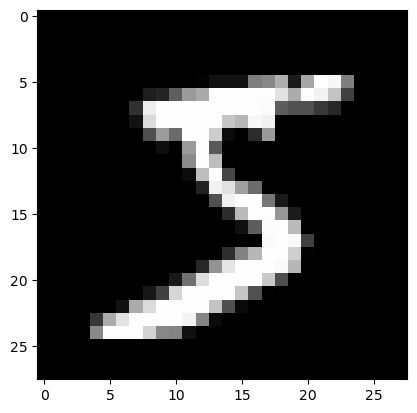

In [14]:
first_image_np = X_tr[0].reshape(28, 28)
first_image_label = Y_tr[0]
print(f'The first image in the training set is labeled "{first_image_label}."')
plt.imshow(first_image_np, cmap='gray')
plt.show()

# Logistic Regression
Now, let's fit a _simple_ logistic regression model to it. We're going to use plain old cross entropy loss with no regularization to keep things nice and simple (I have a suspicion that lasso regularization would make the model "ignore" "unimportant" pixels and greatly increase performance)-- this is about nonlinear dimensionality reduction, not logistic regression hyperparameter tuning. We'll fit with one epoch of stochastic gradient descent.

In [15]:
naive_logreg = LogisticRegression(max_iter=10, penalty=None, solver='saga')
time_start = time.time()
naive_logreg.fit(X_tr, Y_tr)
time_end = time.time()
preds = naive_logreg.predict(X_te)
acc = accuracy_score(Y_te, preds)
print(f'Naive linear model achieved {acc * 100}% accuracy in {time_end - time_start:.2f} seconds.')

Naive linear model achieved 92.62% accuracy in 18.69 seconds.


c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


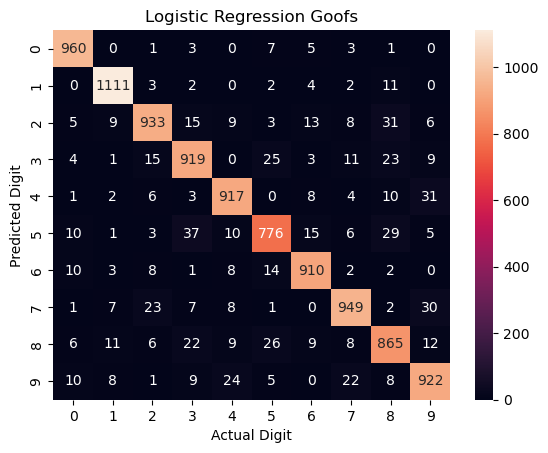

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_te, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Logistic Regression Goofs')
plt.xlabel('Actual Digit')
plt.ylabel('Predicted Digit')
plt.show()

About expected: what stands out is that the model thinks 8s are 2s and 4s are 9s.

# PCA, _then_ logistic regression
Now, let's try doing PCA on the data and seeing if that increases performance. The digits were originally 28x28; we'll try getting them down to 8x8 and seeing if that looks good.

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_tr_pca = pca.fit_transform(X_tr)
X_te_pca = pca.transform(X_te)

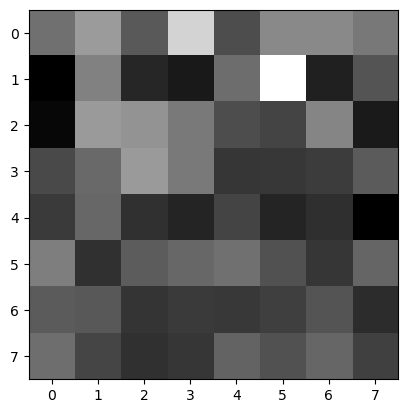

In [40]:
first_img_reduced_np = X_tr_pca[0].reshape(8, 8)
plt.imshow(first_img_reduced_np, cmap='gray')
plt.show()

In [42]:
naive_logreg_pca = LogisticRegression(max_iter=10, penalty=None, solver='saga')
time_start = time.time()
naive_logreg.fit(X_tr_pca, Y_tr)
time_end = time.time()
preds = naive_logreg.predict(X_te_pca)
acc = accuracy_score(Y_te, preds)
print(f'Linear model with PCA achieved {acc * 100}% accuracy in {time_end - time_start:.2f} seconds.')

Linear model with PCA achieved 91.69% accuracy in 1.69 seconds.


c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We can see that that was comically bad: reducing the dimension of the dataset _decreased_ the linear model's accuracy. (In all seriousness, I squished the images down to 8x8 to make a point, but 20x20 also didn't increase accuracy.)

# That's not a knife: Convolutional Neural Network
I know that at first glance, over 90% accuracy for handwritten digits still seems pretty good, but I promise that's pretty poor for this dataset. Now, we'll break out the big guns and get _over 99%_ accuracy with a convolutional neural network, which is a black box model that generally _kicks ass_ at this sort of task. 

> How a CNN works is out of the scope of this notebook; the goal here is to show what's a "good" accuracy. No GPU, no Apple Silicon (this is an eight year-old ThinkPad): just solid architecture and hyperparameters and a few minutes of training. Like a Minecraft video I did architecture and hyperparameter tuning off camera (several months ago, when I learned what CNNs are in class).

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(SEED)

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 32)
        x = self.dropout(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [22]:
# reshaping to be in grids again to play nice with convolution
X_tr_pt = torch.from_numpy(X_tr.reshape(-1, 1, 28, 28)).float()
X_te_pt = torch.from_numpy(X_te.reshape(-1, 1, 28, 28)).float()
Y_tr_pt = torch.from_numpy(Y_tr)
Y_te_pt = torch.from_numpy(Y_te)

train_loader = DataLoader(TensorDataset(X_tr_pt, Y_tr_pt), batch_size=64, shuffle=True)
# test_loader = DataLoader(TensorDataset(X_te_pt, Y_te_pt), batch_size=64, shuffle=False)

In [23]:
LEARNING_RATE = 0.001
EPOCHS = 10

model = SimpleCNN()
crit = nn.CrossEntropyLoss()
adam = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_start = time.time()
for epoch in tqdm(range(EPOCHS)):
    ep_start = time.time()
    model.train()
    ep_loss = 0.0
    for x, y in train_loader:
        adam.zero_grad()
        preds = model(x)
        loss = crit(preds, y)
        loss.backward()
        adam.step()
        ep_loss += loss.item()

    ep_end = time.time()

    print(f'Epoch {epoch + 1}/{EPOCHS}: Loss = {ep_loss/len(train_loader):.2f} in {ep_end - ep_start:.2f}s')

train_end = time.time()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Loss = 0.35 in 17.91s
Epoch 2/10: Loss = 0.13 in 20.83s
Epoch 3/10: Loss = 0.10 in 20.54s
Epoch 4/10: Loss = 0.09 in 23.86s
Epoch 5/10: Loss = 0.08 in 26.27s
Epoch 6/10: Loss = 0.07 in 26.00s
Epoch 7/10: Loss = 0.06 in 25.15s
Epoch 8/10: Loss = 0.06 in 24.92s
Epoch 9/10: Loss = 0.06 in 24.94s
Epoch 10/10: Loss = 0.05 in 27.25s


In [24]:
train_mins = int((train_end - train_start) // 60)
train_secs = int((train_end - train_start) % 60)
print(f'Finished training in {train_mins}:{train_secs}.')

Finished training in 3:57.


In [25]:
torch.save(model, 'CNN.pth')

In [26]:
loaded_model = torch.load('CNN.pth')
loaded_model.eval()

with torch.no_grad():
    out = loaded_model(X_te_pt)
    _, preds = torch.max(out, 1)

In [27]:
model_acc = 100 * ((preds == Y_te_pt).sum().item() / len(preds)) # functional!
print(f'Model achieved {model_acc:.2f}% accuracy in just over 4 minutes.')

Model achieved 99.16% accuracy in just over 4 minutes.


That's an undeniable improvement over the linear model: it should show that we can do much better than 92%.

![](thanos.png)

For reference, the best any lab's gotten is 99.87%: `https://paperswithcode.com/sota/image-classification-on-mnist`.

# Autoencoders
Now, let's see if we can increase the accuracy of a linear model by doing _nonlinear_ dimension reduction. An autoencoder is a neural network that learns the best way to "squish" high-dimensional data down into a lower-dimensional space _without losing information_, based on how well it can reconstruct the original input from its "squished" representation. I'll also make it with a nice `sklearn`-like `fit_transform()` API.

I'm using the Leaky ReLU for my hidden activation functions because I've found better results in the past with it (once...) than plain old ReLU.

In [28]:
class Autoencoder_64(nn.Module):
    def __init__(self):
        super().__init__()
        # this is what "squishes"
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
        )
        
        # this is what "stretches"
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded =  self.decoder(encoded)
        return decoded
    
    # x is the numpy array, already flattened and normalized
    def fit(self, x, epochs=10, learning_rate=0.001, verbose=True):
        self.train()
        loader = DataLoader(torch.from_numpy(x).float(), batch_size=64, shuffle=True)
        adam = optim.Adam(self.parameters(), lr=learning_rate)
        crit = nn.MSELoss()
        train_start = time.time()
        for epoch in tqdm(range(epochs)):
            ep_start = time.time()
            ep_loss = 0.0
            for x in loader:
                adam.zero_grad()
                reconstructed = self(x)
                loss = crit(x, reconstructed)
                loss.backward()
                adam.step()
                ep_loss += loss.item()
            ep_end = time.time()
            if verbose:
                print(f'Epoch {epoch + 1}/{epochs}: Loss = {ep_loss/len(loader):.2f} in {ep_end - ep_start:.2f}s')
        train_end = time.time()
        if verbose:
            train_mins = int((train_end - train_start) // 60)
            train_secs = int((train_end - train_start) % 60)
            fname = 'ae_64.pth'
            print(f'Finished training in {train_mins}:{train_secs}.')
            print(f'Saving as {fname}.')
        torch.save(self, fname)
        return self

    # takes in and outputs numpy
    def transform(self, x):
        self.eval()
        with torch.no_grad():
            out = self.encoder(torch.from_numpy(x).float()).numpy()
        return out
    
    def fit_transform(self, x, epochs=10, learning_rate=0.001, verbose=True):
        self.fit(x, epochs=epochs, learning_rate=learning_rate, verbose=verbose)
        out = self.transform(x)
        return out
    
    def reconstruct(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.from_numpy(x).float()
            out = self(x_tensor).numpy()
        return out

In [29]:
ae64 = Autoencoder_64()
transformed = ae64.fit_transform(X_tr)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Loss = 0.04 in 22.51s
Epoch 2/10: Loss = 0.02 in 23.80s
Epoch 3/10: Loss = 0.02 in 21.61s
Epoch 4/10: Loss = 0.01 in 22.52s
Epoch 5/10: Loss = 0.01 in 22.37s
Epoch 6/10: Loss = 0.01 in 20.27s
Epoch 7/10: Loss = 0.01 in 20.15s
Epoch 8/10: Loss = 0.01 in 20.29s
Epoch 9/10: Loss = 0.01 in 20.46s
Epoch 10/10: Loss = 0.01 in 19.52s
Finished training in 3:33.
Saving as ae_64.pth.


Anyway, let's now take a look at the 8x8 images the autoencoder made, as well as its reconstructions. As you can see, while the squished representations don't look like a 5 or a 0, you can see from the reconstructions that the model did successfully learn a squished representation that captures important information!

In [30]:
ae64 = torch.load('ae_64.pth')
transformed = ae64.transform(X_tr)
reconstructed = ae64.reconstruct(X_tr)

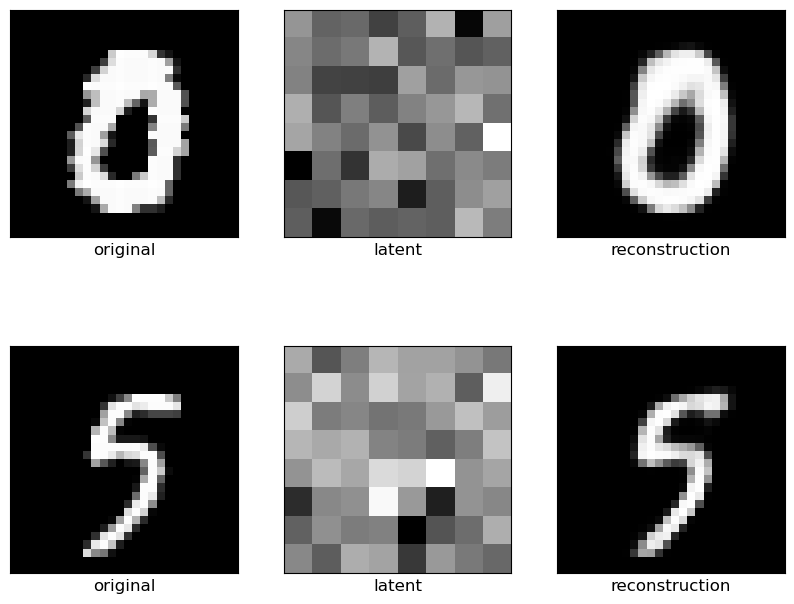

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

axs[0, 0].imshow(X_tr[69].reshape(28, 28), cmap='gray')
axs[0, 1].imshow(transformed[69].reshape(8, 8), cmap='gray')
axs[0, 2].imshow(reconstructed[69].reshape(28, 28), cmap='gray')
axs[1, 0].imshow(X_tr[420].reshape(28, 28), cmap='gray')
axs[1, 1].imshow(transformed[420].reshape(8, 8), cmap='gray')
axs[1, 2].imshow(reconstructed[420].reshape(28, 28), cmap='gray')

column_labels = ['original', 'latent', 'reconstruction']
for i in range(len(axs)):
    for ax, label in zip(axs[i], column_labels):
        ax.set_xlabel(label, fontsize=12)
plt.show()

Here's PCA doing the same thing, for reference. You'll see that the reconstruction is much less sharp: you, as a human, can see what they meant, but the weird, swirly patterns around the edges, as well as the gray background, clearly were throwing the model off.

In [32]:
from sklearn.decomposition import PCA
pca_64 = PCA(n_components=64)
pca_transformed = pca_64.fit_transform(X_tr)
pca_reconstructed = pca_64.inverse_transform(pca_transformed)

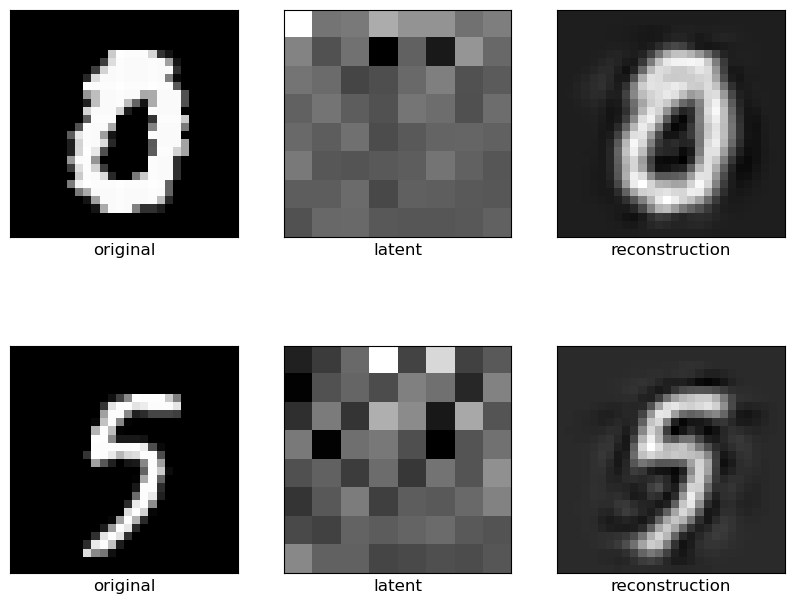

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

axs[0, 0].imshow(X_tr[69].reshape(28, 28), cmap='gray')
axs[0, 1].imshow(pca_transformed[69].reshape(8, 8), cmap='gray')
axs[0, 2].imshow(pca_reconstructed[69].reshape(28, 28), cmap='gray')
axs[1, 0].imshow(X_tr[420].reshape(28, 28), cmap='gray')
axs[1, 1].imshow(pca_transformed[420].reshape(8, 8), cmap='gray')
axs[1, 2].imshow(pca_reconstructed[420].reshape(28, 28), cmap='gray')

column_labels = ['original', 'latent', 'reconstruction']
for i in range(len(axs)):
    for ax, label in zip(axs[i], column_labels):
        ax.set_xlabel(label, fontsize=12)
plt.show()

Finally, let's see how well the linear classifier worked.

In [34]:
transform_start = time.time()
test_ae = ae64.transform(X_te)
transform_end = time.time()
ae_logreg = LogisticRegression(max_iter=10, penalty=None, solver='saga')
time_start = time.time()
ae_logreg.fit(transformed, Y_tr)
time_end = time.time()
ae_preds = ae_logreg.predict(test_ae)
acc = accuracy_score(Y_te, ae_preds)

c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [37]:
transform_time = transform_end - transform_start
lr_time = time_end - time_start
inf_time = transform_time + lr_time
print(f'Autoencoder transformed test set in {transform_end - transform_start:.2f} seconds.')
print(f'Autoencoder + linear model achieved {(acc * 100):.2f}% accuracy in {inf_time:.2f} seconds.')

Autoencoder transformed test set in 0.11 seconds.
Autoencoder + linear model achieved 94.98% accuracy in 2.77 seconds.


# Conclusion
<img src="lfg.png" width="350"/>

I think that there's plenty more gains to be had. I made the autoencoder, which was the core of this little inference pipeline, in a pretty careless fashion:

- I didn't do any kind of architecture or hyperparameter tuning-- I just went with what felt right, and 
- I just used a standard (as opposed to denoising) autoencoder, _and_ 
- I didn't include any supervised aspect (including the label in the loss when training). 

But I think that I was able to show that autoencoders are capable of automatically engineering useful features for linear models in a way that principal component analysis isn't. Thanks for reading!